In [88]:
#Importing libraries.
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
import datetime
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import cross_validation
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import warnings

In [89]:
#Load data into pandas.
Data = pd.read_csv(r'C:\Users\00008020\.spyder-py3\python_programs\python_codes\XYZCorp_LendingData.txt', delimiter='\t',low_memory=False,header =0)

loan_data = pd.DataFrame(Data)

In [90]:
# count half point of the dataset.Remove NA values more than 50%.
half_point = len(loan_data) / 2
print (half_point)
loan_data = loan_data.dropna(thresh=half_point, axis=1)

427984.5


In [33]:
loan_data.isnull().sum()
#(855969, 52)

id                                 0
member_id                          0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                      49443
emp_length                     43061
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
pymnt_plan                         0
purpose                            0
title                             33
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                        0
earliest_cr_line                   0
inq_last_6mths                     0
open_acc                           0
pub_rec                            0
r

In [92]:
#eliminating irrelevant values
#application type have almost constant value:individual and  442 obs have value:joint
#constant values doesn't affect regression
#address state have too many unique values
drop_list = ['id','member_id','sub_grade','emp_title','zip_code','addr_state','pymnt_plan',
             'application_type','next_pymnt_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line',
             'initial_list_status']
loan_data = loan_data.drop(drop_list,axis=1)

#using date variable type 1 error is increasing thats why we are eliminating them and also
#date variable requires potential engineering thats why its better to drop all the date variables
#initial list status:type 1 error increases if this feature is included,hence we eliminated it
#(855969, 39)

In [51]:
for column in loan_data.columns:
    if (len(loan_data[column].unique()) < 4):
        print(loan_data[column].value_counts())
        print()

 36 months    600221
 60 months    255748
Name: term, dtype: int64

Source Verified    318178
Verified           280049
Not Verified       257742
Name: verification_status, dtype: int64

1.0    855969
Name: policy_code, dtype: int64

0    809502
1     46467
Name: default_ind, dtype: int64



In [94]:
loan_data=loan_data.drop("policy_code",axis=1)
#(855969, 38)

In [40]:
# purpose & title columns contains overlapping information. But purpose column contains fewer descrete values & is cleaner 

for name in ['purpose','title']:
    print("Unique Values in column: {}\n".format(name)) 
    print(loan_data[name].value_counts(),'\n')


Unique Values in column: purpose

debt_consolidation    505392
credit_card           200144
home_improvement       49956
other                  40949
major_purchase         16587
small_business          9785
car                     8593
medical                 8193
moving                  5160
vacation                4542
house                   3513
wedding                 2280
renewable_energy         549
educational              326
Name: purpose, dtype: int64 

Unique Values in column: title

Debt consolidation                          398089
Credit card refinancing                     159228
Home improvement                             38633
Other                                        30522
Debt Consolidation                           15469
Major purchase                               11519
Medical expenses                              6408
Business                                      6325
Car financing                                 5372
Consolidation                          

In [96]:
# we drop title here based on above obs
loan_data = loan_data.drop("title", axis=1)
#(855969, 37)

In [98]:
# Filling NA values
loan_data['emp_length']=loan_data['emp_length'].fillna(0)
col_name2=['revol_util','collections_12_mths_ex_med',
'tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
for x in col_name2: loan_data[x].fillna(loan_data[x].mean(),inplace=True)

In [99]:
#we are getting mode value as 10+year in emp_length so it can't be consider for filling NA.here all the null
#obs are filled with '0' in above code block and for rest mapping is used below.
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
    }
}
loan_data= loan_data.replace(mapping_dict)
loan_data['emp_length'].head()


0    10
1     0
2    10
3    10
4     1
Name: emp_length, dtype: int64

In [100]:
#%%Label encoding
colname=["grade","home_ownership", "verification_status", "purpose",
         "term"]
le={}
for x in colname:
    le[x]=preprocessing.LabelEncoder()

for x in colname:
    loan_data[x]=le[x].fit_transform(loan_data.__getattr__(x))

In [84]:
#Multicolinearity
cor =loan_data.corr() 
cor.loc[:,:] = np.tril(cor, k=-2) # below main lower triangle of an array

cor = cor.stack()
cor[(cor > 0.9) | (cor < -0.9)]#only highly correlated values are considered here

funded_amnt_inv  loan_amnt          0.997601
installment      loan_amnt          0.944870
                 funded_amnt        0.945903
                 funded_amnt_inv    0.944149
grade            int_rate           0.954900
total_rec_prncp  total_pymnt        0.970594
dtype: float64

Text(0.5,1,'Correlation Heat Map')

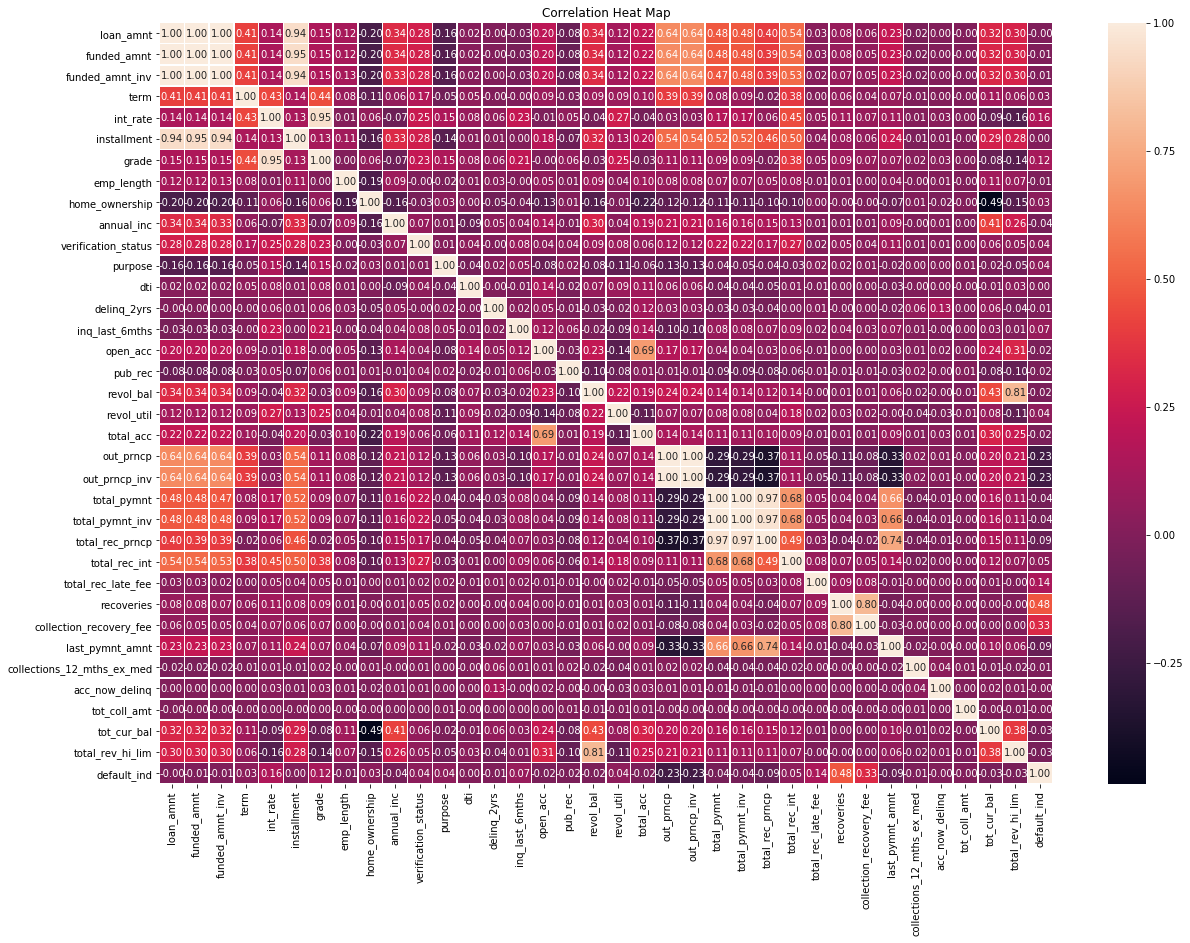

In [103]:
plt.figure(figsize=(20,14))
sns.heatmap(loan_data.corr(), annot=True, linewidths=.5,fmt='.2f')
plt.title('Correlation Heat Map')

In [104]:
#based on multicollinearity we are droping the below mentioned columns
loan_data=loan_data.drop(['int_rate',"funded_amnt_inv","installment","total_rec_prncp",],axis=1)
#(855969, 33)

In [105]:
loan_data.isnull().sum()


loan_amnt                     0
funded_amnt                   0
term                          0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_re

In [107]:
print("We've been able to reduced the features to => {}".format(loan_data.shape))


We've been able to reduced the features to => (855969, 33)


In [108]:
#%%Splitting data using'issue_d'.

loan_data['issue_d']=pd.to_datetime(loan_data['issue_d'],format='%b-%Y')

train_data=loan_data[loan_data['issue_d']<'2015-06-01']

test_data=loan_data[loan_data['issue_d'] >='2015-06-01']

train_data = train_data.drop("issue_d",axis=1)
test_data = test_data.drop("issue_d",axis=1)


x_train=train_data.values[:,:-1]#all columns except last,negative indexing
y_train=train_data.values[:,-1]#all rows of last column
x_test=test_data.values[:,:-1]
y_test=test_data.values[:,-1] 


In [109]:
#%%------------------Logistic----------------------------------

#create model
classifier=(LogisticRegression())
#fitting training data to model
classifier.fit(x_train,y_train)
#predicting
y_pred=classifier.predict(x_test)

In [110]:
#creating confusion matrix

cfm=confusion_matrix(y_test,y_pred)
print(cfm)
print("Classification report:")
print(classification_report(y_test,y_pred))
acc=accuracy_score(y_test,y_pred)
print("accuracy of model is:",acc)

[[256636     44]
 [    63    248]]
Classification report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    256680
        1.0       0.85      0.80      0.82       311

avg / total       1.00      1.00      1.00    256991

accuracy of model is: 0.9995836430069536


In [111]:
y_pred_prob=classifier.predict_proba(x_test)
print(y_pred_prob)


[[9.99994281e-01 5.71916083e-06]
 [9.99948044e-01 5.19556757e-05]
 [9.87228087e-01 1.27719131e-02]
 ...
 [9.99975264e-01 2.47362794e-05]
 [9.99975138e-01 2.48623560e-05]
 [9.99998948e-01 1.05245431e-06]]


In [112]:
#Adusting threshod.
for a in np.arange(0,1,0.05):
    predict_mine=np.where(y_pred_prob[:,0]<a,1,0)
    cfm=confusion_matrix(y_test.tolist(),predict_mine)
    total_err=cfm[0,1]+cfm[1,0]
    print("errors at threshold",a,":",total_err,"type 2 error :",\
          cfm[1,0],"type 1 error:",cfm[0,1])

errors at threshold 0.0 : 311 type 2 error : 311 type 1 error: 0
errors at threshold 0.05 : 74 type 2 error : 63 type 1 error: 11
errors at threshold 0.1 : 82 type 2 error : 63 type 1 error: 19
errors at threshold 0.15000000000000002 : 86 type 2 error : 63 type 1 error: 23
errors at threshold 0.2 : 88 type 2 error : 63 type 1 error: 25
errors at threshold 0.25 : 90 type 2 error : 63 type 1 error: 27
errors at threshold 0.30000000000000004 : 93 type 2 error : 63 type 1 error: 30
errors at threshold 0.35000000000000003 : 93 type 2 error : 63 type 1 error: 30
errors at threshold 0.4 : 96 type 2 error : 63 type 1 error: 33
errors at threshold 0.45 : 104 type 2 error : 63 type 1 error: 41
errors at threshold 0.5 : 107 type 2 error : 63 type 1 error: 44
errors at threshold 0.55 : 108 type 2 error : 63 type 1 error: 45
errors at threshold 0.6000000000000001 : 112 type 2 error : 63 type 1 error: 49
errors at threshold 0.65 : 115 type 2 error : 63 type 1 error: 52
errors at threshold 0.70000000

In [113]:
y_pred_class=[]
for value in y_pred_prob[:,0]:
    if value <0.4:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

In [114]:
cfm=confusion_matrix(y_test.tolist(),y_pred_class)
print(cfm)
acc=accuracy_score(y_test.tolist(),y_pred_class)
print("accuracy of model is:",acc) 
print("Classification report:") 
print(classification_report(y_test.tolist(),y_pred_class))  

[[256647     33]
 [    63    248]]
accuracy of model is: 0.9996264460623134
Classification report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    256680
        1.0       0.88      0.80      0.84       311

avg / total       1.00      1.00      1.00    256991



In [115]:
fpr,tpr,threshold=metrics.roc_curve(y_test.tolist(),y_pred_class)
auc=metrics.auc(fpr,tpr)
print("auc:",auc)

auc: 0.898649543991618


Text(0,0.5,'true +ve rate')

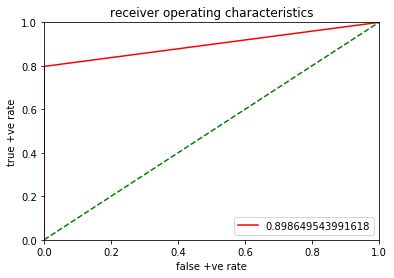

In [116]:
plt.title("receiver operating characteristics")
plt.plot(fpr,tpr,'r',label=auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([0,1])   
plt.ylim([0,1])
plt.xlabel('false +ve rate')
plt.ylabel('true +ve rate') 
#plt.show()

In [117]:
#k-folds cross validation used for evaluation of model
#in k-folds cross-validation no drastic change in accuracy score is found hence original model is preferred
classifier=(LogisticRegression())
from sklearn import cross_validation
#performing kfold_cross_validation
kfold_cv=cross_validation.KFold(n=len(x_train),n_folds=10)
print(kfold_cv)

#running the model using scoring metric as accuracy
kfold_cv_result=cross_validation.cross_val_score(estimator=classifier,X=x_train,
y=y_train, cv=kfold_cv)
print(kfold_cv_result)
#finding the mean
print(kfold_cv_result.mean())

for train_value, test_value in kfold_cv:
    classifier.fit(x_train[train_value], y_train[train_value]).predict(x_train[test_value])


    y_pred=classifier.predict(x_test)
warnings.filterwarnings('ignore')

sklearn.cross_validation.KFold(n=598978, n_folds=10, shuffle=False, random_state=None)
[0.97831313 0.99813015 0.99754583 0.99355571 0.99737888 0.99667769
 0.99677786 0.99749574 0.99782961 0.99734544]
0.9951050037982079


In [118]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
cfm=confusion_matrix(y_test,y_pred)
print(cfm)
acc=accuracy_score(y_test,y_pred)
print("accuracy of model is:",acc) 
print("Classification report:") 
print(classification_report(y_test,y_pred)) 

[[256638     42]
 [    63    248]]
accuracy of model is: 0.9995914253806554
Classification report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    256680
        1.0       0.86      0.80      0.83       311

avg / total       1.00      1.00      1.00    256991



In [70]:
from sklearn.ensemble import AdaBoostClassifier
classifier=(LogisticRegression())
model_AdaBoost=(AdaBoostClassifier(base_estimator=classifier))
model_AdaBoost.fit(x_train,y_train)
y_pred=model_AdaBoost.predict(x_test)
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
#confusion matrix
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
#[[253872   2703]
# [    60    251]]
#0.9892442562070335
#            precision    recall  f1-score   support

#      0.0       1.00      0.99      0.99    256575
#     1.0       0.08      0.81      0.15       311

#avg / total       1.00      0.99      0.99    256886'''

In [122]:
test_data["predicted_y"]=y_pred_class

test_data.to_csv(r"C:\Users\00008020\.spyder-py3\python_programs\python_codes\test_data_predicted.csv",index=False)